### Convert SDO/AIA data from level 1 to level 1.5

AIA data products provides by the JSOC are level 1 data products.  
This means that the images still include the roll angle of the satellite and each channel may have a slightly different pixel scale.  
Typically, before performing any sort of data analysis on AIA images, you will want to promote your AIA data from level 1 to level 1.5.

1. Pointing correction (aiapy.calibrate.update_pointing)  
2. Image respiking (aiapy.calibrate.respike)  
3. PSF deconvolution (aiapy.psf.deconvolve)  
4. Registration (aiapy.calibrate.register)  
5. Degradation correction (aiapy.calibrate.correct_degradation)  
6. Exposure normalization

In this code, we only use method 1, 4, 5, and 6.

Reference.
https://aiapy.readthedocs.io/en/stable/preparing_data.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u

import sunpy

import aiapy
from aiapy.calibrate.util import get_pointing_table
from aiapy.calibrate.util import get_correction_table

from convert_to_level1_5 import convert_to_level1_5

__all__ = ["update_pointing"]

In [2]:
"""gool quality"""
# level 1
#fits_file = r"E:\Research\SR\input\CH_Indices\EUV_level1\193\2017\aia.lev1_euv_12s.2017-08-10T000006Z.193.image_lev1.fits"

"""bad quality"""
# # name 'strip_invalid_blank' is not defined
fits_file = r"E:\Research\SR\input\CH_Indices\EUV_level1\193\2013\aia.lev1_euv_12s.2013-11-01T000008Z.193.image_lev1.fits"
# -> 해결됨.

# No valid entries for 2013-02-04T12:00:07.838 in pointing table with first T_START date and a last T_STOP date
#fits_file = r"E:\Research\SR\input\CH_Indices\EUV_level1\193\2012\aia.lev1_euv_12s.2012-12-30T120008Z.193.image_lev1.fits"
# -> 해결됨.

# Input must be a full disk image.
#fits_file = r"E:\Research\SR\input\CH_Indices\EUV_level1\193\2019\aia.lev1_euv_12s.2019-07-24T120005Z.193.image_lev1.fits"
# -> 어쩔 수 없음.

# Failed to read
# aia.lev1_euv_12s.2020-12-17T000006Z.193.image_lev1.fits
# aia.lev1_euv_12s.2024-12-23T120006Z.193.image_lev1.fits
# aia.lev1_euv_12s.2017-04-25T235959Z.211.image_lev1.fits
# aia.lev1_euv_12s.2020-12-18T235959Z.211.image_lev1.fits
# aia.lev1_euv_12s.2024-12-19T235959Z.211.image_lev1.fits
#fits_file = r"E:\Research\SR\input\CH_Indices\EUV_level1\193\2020\aia.lev1_euv_12s.2020-12-17T000006Z.193.image_lev1.fits"
# -> 안 열림

# unsupported operand type(s) for *: 'NoneType' and 'Unit'
# aia.lev1_euv_12s.2021-03-18T235959Z.211.image_lev1.fits 
# aia.lev1_euv_12s.2021-04-29T115959Z.211.image_lev1.fits 
#fits_file = r"E:\Research\SR\input\CH_Indices\EUV_level1\211\2021\aia.lev1_euv_12s.2021-03-18T235959Z.211.image_lev1.fits"
# -> 안 열림

aia_map = sunpy.map.Map(fits_file)
type(aia_map)

sunpy.map.sources.sdo.AIAMap

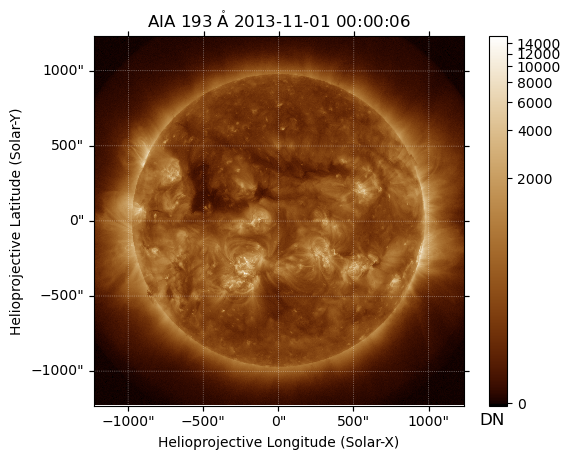

In [3]:
aia_map.peek()

#### 1. Pointing correction

aiapy.calibrate.update_pointing(smap, *, pointing_table)

pointing_table = ``get_pointing_table``  
: This method removes any ``PCi_j`` matrix keys in the header and updates the ``CROTA2`` keyword.

In [4]:
pointing_tbl = get_pointing_table(
    "lmsal",
    time_range=(aia_map.date - 6*u.hour, aia_map.date + 6*u.hour)
)
if aia_map.meta.get("SAT_ROT") is None:
    aia_map.meta["SAT_ROT"] = 0.0

aia_map_pt = aiapy.calibrate.update_pointing(aia_map, pointing_table=pointing_tbl)

In [5]:
# To check a change.
# CRPIX: reference point
# CDELT: 
for key in ["CRPIX1","CRPIX2","CDELT1","CDELT2", "CROTA2"]:
    print(key, "before:", aia_map.meta[key], "after:", aia_map_pt.meta[key])


CRPIX1 before: 2042.80005 after: 2042.594849
CRPIX2 before: 2044.42004 after: 2044.238159
CDELT1 before: 0.600714028 after: 0.600714
CDELT2 before: 0.600714028 after: 0.600714
CROTA2 before: 0.0575973354 after: 0.057597335226


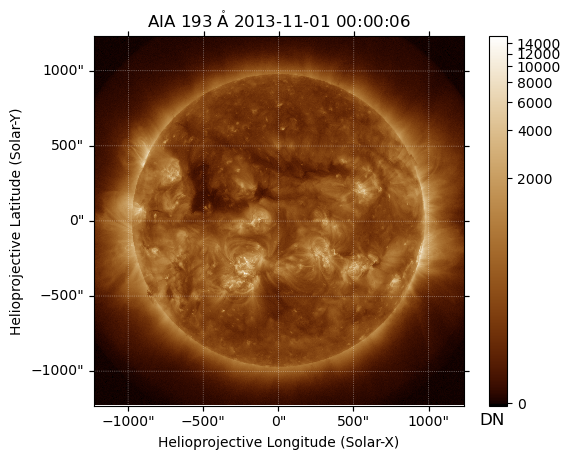

In [6]:
aia_map_pt.peek()

#### 2. Registration

In [7]:
aia_map_reg = aiapy.calibrate.register(
    aia_map_pt,
    missing=np.nan,     # extrapolation: fill with NaN
    order=3,            # interpolation: bicubic        
    method='scipy'      # Rotation function to use: scipy
)

In [8]:
# To check a change.
for key in ["CRPIX1","CRPIX2","CDELT1","CDELT2"]:
    print(key, "before:", aia_map_pt.meta[key], "after:", aia_map_reg.meta[key])

CRPIX1 before: 2042.594849 after: 2048.5
CRPIX2 before: 2044.238159 after: 2048.5
CDELT1 before: 0.600714 after: 0.6
CDELT2 before: 0.600714 after: 0.6


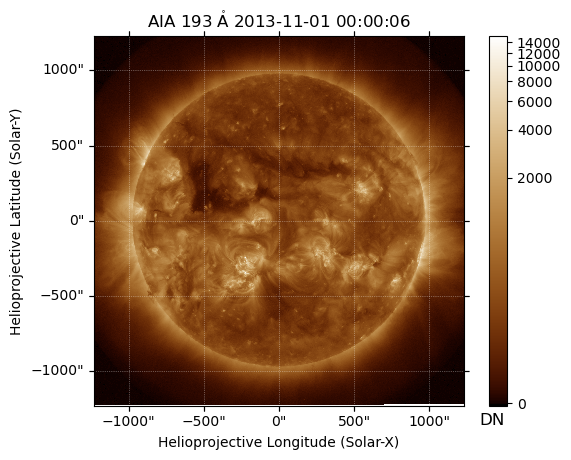

In [9]:
aia_map_reg.peek()

#### 3. Degradation correction

In [10]:
corr_tbl = get_correction_table("SSW")

aia_map_cal = aiapy.calibrate.correct_degradation(
    aia_map_reg,
    correction_table=corr_tbl
)

In [11]:
print("before:", aia_map_reg.date.isot, " after:", aia_map_cal.date.isot)

before: 2013-11-01T00:00:06.844  after: 2013-11-01T00:00:06.844


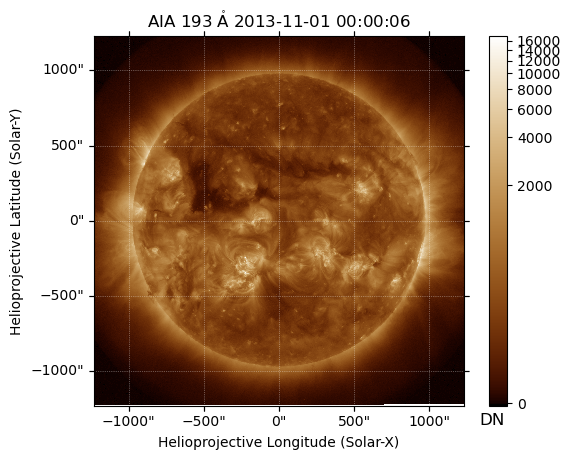

In [12]:
aia_map_cal.peek()

#### 4. Exposure normalization

In [13]:
exp_time = aia_map_cal.exposure_time

aia_map_norm = aia_map_cal / exp_time

Observatory,SDO
Instrument,AIA 2
Detector,AIA
Measurement,193.0 Angstrom
Wavelength,193.0 Angstrom
Observation Date,2013-11-01 00:00:06
Exposure Time,2.000032 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.6 0.6] arcsec / pix
Reference Pixel,[2047.5 2047.5] pix

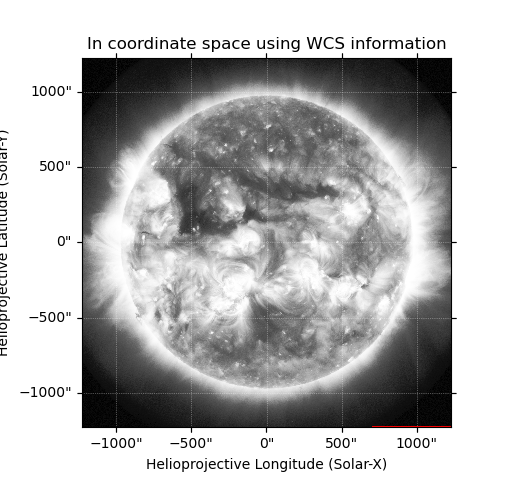
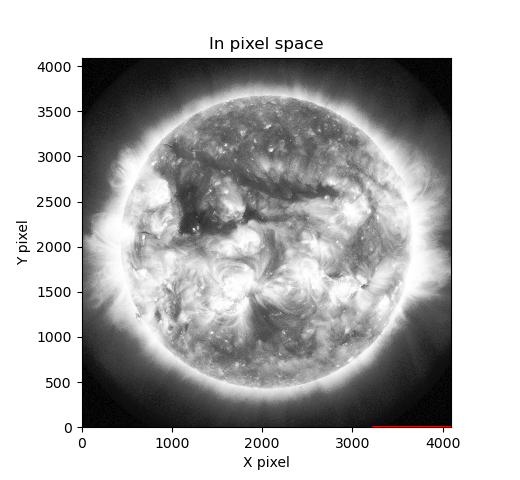
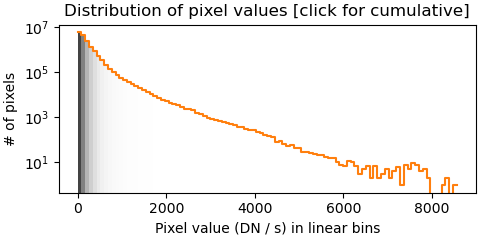
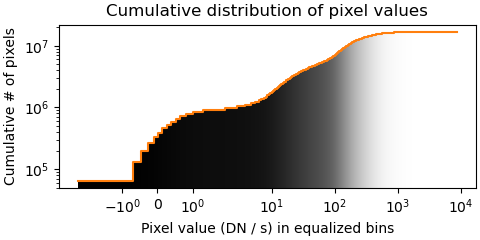

In [14]:
aia_map_norm

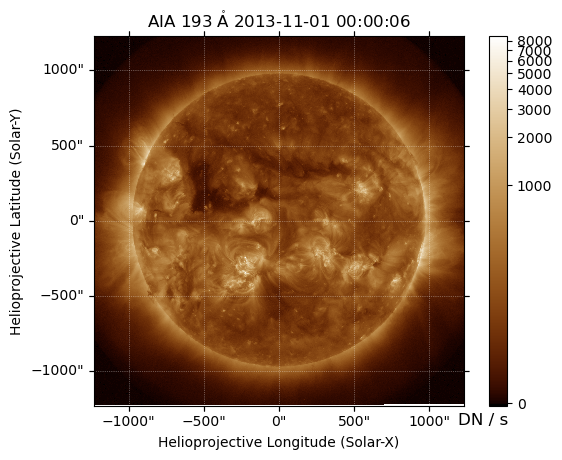

In [15]:
aia_map_norm.peek()

---